# HW2 due 5p Fri Oct 22 2021

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission (e.g. the .ipynb file).

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file).

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.

**Also important:** To produce a .pdf for submission to Canvas, click "File -> Print" (or press Ctrl/Cmd + P), and choose "Save to PDF" or "Microsoft Print to PDF" as your printer.


# 0. [Nakseung Choi]; [He/Him/His]

a. Approximately how many hours did you spend on this assignment

   15+ hours

b. Were there specific problems that took much longer than others?
   
   Problem 2 took me a while to finish. 

c. What class meeting(s) did you participate in this week?

   All Zoom meetings

d. What timezone(s) were you working in this week?

   whenever I had time to do.

In [2]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

In [4]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# 1. RLC circuit interconnection

Consider the model of a series RLC circuit from lecture,
$$ L \ddot{q} + R \dot{q} + q/C = v, $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $v$ denotes a series voltage source.

Now suppose that the input voltage $v$ to the circuit above is actually  the output from a second series RLC circuit

$$ L_2 C_2 \ddot{v} + R_2 C_2 \dot{v} + v = w, $$

where $v$ denotes the voltage across the second circuit's capacitor, 
($R_2$, $L_2$, $C_2$) denote the second circuit's (resistor, inductor, capacitor) parameters,
and $w$ denotes a series voltage source for the second circuit.

Let $x = (v,\dot{v})\in\mathbb{R}^2$ denote the second circuit's ***state vector*** and $u = w\in\mathbb{R}^1$ denote the second circuit's ***input vector*** (which is just a scalar since there's only one input)

a. Rewrite the second circuit's single second-order differential equation as a vector of two first-order differential equations in ***state-space*** form as $\dot{x} = f(x,u)$.
$$$$
$$ \dot{x} = \frac{d}{dt}x = \frac{d}{dt} \left[\begin{matrix} v \\ \dot{v} \end{matrix}\right] = \left[\begin{matrix} \dot{v} \\ \ddot{v} \end{matrix}\right] = \left[\begin{matrix} \dot{v} \\ (-R_2C_2\dot{v}-v+w)/L_2C_2 \end{matrix}\right] = f((v,\dot{v}),w)=f(x,u) $$
$$$$

***Purpose:*** in the next two problems, you will investigate a very important algebraic property of the RLC circuit's $f$ function called ***linearity***, which we will study extensively this quarter.  In the first problem, you will show that the function is linear; in the second problem, you will determine a matrix representation for the linear function.

b. Show that the function $f:\mathbb{R}^2\times\mathbb{R}^1\rightarrow\mathbb{R}^2$ you obtained in (a.) is ***linear*** in $x$ and $u$, that is, show:


$$ f(x_1 + \alpha x_2,u_1 + \alpha u_2) = f(x_1,u_1) + \alpha f(x_2,u_2) $$

for arbitrary state vectors $x_1,x_2\in\mathbb{R}^2$, input vectors $u_1,u_2\in\mathbb{R}^1$, and scalar $\alpha\in\mathbb{R}$.

Solution:

$$ f(x,u) = \dot{x} = \left[\begin{matrix} \dot{v} \\ (-R_2C_2\dot{v}-v+w)/L_2C_2 \end{matrix}\right] $$
$$$$
$$ f(x_1 + \alpha x_2,u_1 + \alpha u_2) = \left[\begin{matrix} \dot{(v_1+\alpha v_2)} \\ (-R_2C_2\dot{(v_1+\alpha v_2)}-(v_1+\alpha v_2)+(w_1+\alpha w_2))/L_2C_2 \end{matrix}\right]$$
$$$$
$$ f(x_1 + \alpha x_2,u_1 + \alpha u_2) = \left[\begin{matrix} \dot{v_1}+\dot{\alpha v_2} \\ (-R_2C_2\dot{v_1}-R_2C_2\dot{\alpha v_2}-v_1-\alpha v_2+w_1+\alpha w_2)/L_2C_2 \end{matrix}\right]$$
$$$$
$$ f(x_1 + \alpha x_2,u_1 + \alpha u_2) = \left[\begin{matrix} \dot{v_1} \\ (-R_2C_2\dot{v_1}-v_1+w_1)/L_2C_2 \end{matrix}\right] + \alpha \left[\begin{matrix} \dot{v_2} \\ (-R_2C_2\dot{v_2}-v_2+w_2)/L_2C_2 \end{matrix}\right]$$
$$$$
$$ f(x_1 + \alpha x_2,u_1 + \alpha u_2) = f(x_1,u_1) + \alpha f(x_2,u_2) $$
$$$$

c. Since $f$ is linear, there exist matrices $A\in\mathbb{R}^{2\times 2}$ and $B\in\mathbb{R}^{2\times 1}$ such that $f(x,u) = A x + B u$ for all state vectors $x\in\mathbb{R}^2$ and input vectors $u\in\mathbb{R}^1$ -- determine the entries in the matrices $A$, $B$.
$$$$
$$ \dot{x} = \left[\begin{matrix} \dot{v} \\ \ddot{v} \end{matrix}\right] = Ax+Bu $$
$$$$
$$ \left[\begin{matrix} \dot{v} \\ \ddot{v} \end{matrix}\right] = \left[\begin{matrix} 0 & 1 \\ \frac{-1}{L_2C_2} & \frac{-R_2}{L_2} \end{matrix}\right] \left[\begin{matrix} v \\ \dot{v} \end{matrix}\right]+ \left[\begin{matrix} 0 \\ \frac{1}{L_2C_2} \end{matrix}\right]u$$
$$$$
***Purpose:*** in the next problems, you will see how interconnecting two subsystems affects the different mathematical representations we use in this class; in particular, it will highlight strengths of the block diagram and state-space representations.

d. Determine the transfer functions for the first circuit $P_1(s)$ treating $v$ as the input and $q$ as the output and for the second circuit $P_2(s)$ treating $w$ as the input and $v$ as the output.
$$$$
$$ P_1(s) = G_{qv}(s) $$
$$$$
$$ L \ddot{q} + R \dot{q} + q/C = v $$
$$$$
**Laplace transform to obtain,**
$$$$
$$s^2Lq+sRq+\frac{q}{C}=v$$
$$$$
$$ (s^2L+sR+\frac{1}{C})q=v$$
$$$$
$$\begin{equation}\boxed{G_{qv}=\frac{q}{v}=\frac{1}{s^2L+sR+\frac{1}{C}}}\end{equation}$$
$$$$
**Similary,**
$$$$
$$P_2(s)=G_{vw}(s)$$
$$$$
$$\begin{equation}\boxed{G_{vw}=\frac{v}{w}=\frac{1}{s^2L_2C_2+sR_2C_2+1}}\end{equation}$$
$$$$
**or,**
$$\begin{equation}\boxed{G_{vw}=\frac{v}{w}=\frac{1}{s^2L_2+sR_2+1/C_2}}\end{equation}$$
$$$$

e. Draw and label a block diagram with two blocks (representing the first circuit, $P_1$, and the second circuit, $P_2$) and three arrows (representing the second circuit's input voltage $w$, the second circuit's output / first circuit's input voltage $v$, and the first circuit's output charge $q$).
$$$$
**Answer for this, please check out the other attachment on canvas.**
$$$$



f. Determine the transfer function from $w$ to $q$.  (***Hint:*** it may help to apply block diagram algebra.)
$$$$
$$\frac{q}{w}=\frac{1}{s^4L_2C_2L + s^3L_2C_2R + \frac{s^2L_2C_2}{C} + s^3R_2C_2L + s^2R_2C_2R + s\frac{R_2C_2}{C} + s^2L + sR + \frac{1}{C}}$$
$$$$
$$= \frac{1}{s^4L_2C_2L + s^3(L_2C_2R+R_2C_2L) + s^2(\frac{L_2C_2}{C}+R_2C_2R+L) + s(\frac{R_2C_2}{C}+R) + \frac{1}{C} }$$
$$$$
g. Determine the fourth-order differential equation that relates input $w$ to output $q$.  (***Hint:*** you can use your answer from (e.), or you can substitute the second circuit's DE into the first circuit's DE -- both strategies will give the same answer, so use whichever makes the most sense to you.)

$$$$
$$ w= \ddddot{q}(L_2C_2L) + \dddot{q}(L_2C_2R+R_2C_2L) + \ddot{q}(\frac{L_2C_2}{C}+R_2C_2R+L) + \dot{q}(\frac{R_2C_2}{C}+R) + q\frac{1}{C}$$
$$$$

h. Letting $x = (q,\dot{q},v,\dot{v})\in\mathbb{R}^4$ denote the state vector for the interconnected circuits and $u = w\in\mathbb{R}^1$ denote the input vector, determine the function $f:\mathbb{R}^4\times\mathbb{R}^1\rightarrow\mathbb{R}^4$ for which $\dot{x} = f(x,u)$.

$$$$
$$\frac{dx}{dt}=\dot{x}=f(x,u)$$
$$$$
$$\frac{d}{dt} \left[\begin{matrix} q \\ \dot{q} \\ v \\ \dot{v} \end{matrix}\right] = \left[\begin{matrix} \dot{q} \\ \frac{1}{L}(v-R\dot{q}-\frac{q}{c}) \\ \dot{v} \\ \frac{1}{L_2C_2}(w-R_2C_2\dot{v}-v) \end{matrix}\right] = f(x,u)$$
$$$$


***Reflect:*** which of the 4 representations for the interconnected circuits in (e.--h.) was easiest to work with?  most intuitive?  easiest to generalize to additional interconnected circuits?

i. Noting that the function $f:\mathbb{R}^4\times\mathbb{R}^1\rightarrow\mathbb{R}^4$ from (h.) is linear, determine matrices $A\in\mathbb{R}^{4\times4}$, $B\in\mathbb{R}^{4\times1}$ such that $f(x,u) = A x + B u$.

$$$$
$$f(x,u)=\left[\begin{matrix} 0 & 1 & 0 & 0 \\ \frac{-1}{LC} & \frac{-R}{L} & \frac{1}{L} & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & \frac{-1}{L_2C_2} & \frac{-R_2}{L_2} \end{matrix}\right] \left[\begin{matrix} q \\ \dot{q} \\ v \\ \dot{v} \end{matrix}\right]+\left[\begin{matrix} 0 \\ 0 \\ 0 \\ \frac{1}{L_2C_2}\end{matrix}\right]w $$
$$$$

# 2. phase portraits of linear systems

***Purpose:*** gain greater understanding of the dynamics of linear systems using computational tools and visualizations.

In each of the following problems, you will create a ***phase portrait*** of a linear system with a $2$-dimensional state vector in the form $\dot{x} = A x$.  To create a phase portrait, plot the system's ***vector field*** and overlay several simulated trajectories to illustrate the system's dynamics.  You may find it helpful to edit the simulation and plotting code used in the phase portrait in Section 2 of the [lecture examples notebook](https://colab.research.google.com/github/sburden/447/blob/master/447_lec_examples.ipynb), or to consult Chapter 5.2 in [AMv2](http://www.cds.caltech.edu/~murray/amwiki/index.php/Second_Edition).
$$$$
$$$$
$$$$
**All the answers are presented on the last page.**
$$$$

a. Create a phase portrait for $\dot{x} = A_1 x$ where $A_1 = \left[\begin{matrix} -1 & 0 \\ 0 & -2 \end{matrix}\right]$.

b. Create a phase portrait for $\dot{x} = A_2 x$ where $A_2 = \left[\begin{matrix} -1 & 1 \\ 0 & -1 \end{matrix}\right]$.

c. Create a phase portrait for $\dot{x} = A_3 x$ where $A_3 = \left[\begin{matrix} -1 & 0 \\ 0 & +2 \end{matrix}\right]$.

d. Create a phase portrait for $\dot{x} = A_4 x$ where $A_4 = \left[\begin{matrix} -1 & \pi \\ -\pi & -1 \end{matrix}\right]$.

e. Create a phase portrait for $\dot{x} = A_5 x$ where $A_5 = \left[\begin{matrix} 0 & \pi \\ -\pi & 0 \end{matrix}\right]$.

f. Create a phase portrait for $\dot{z} = T(\theta) A_3 T(\theta)^{-1} z$ where $T(\theta) = \left[\begin{matrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{matrix}\right]$ and $A_3$ is from (c.) -- show the result from several values of $\theta$, and explain in words how the phase portraits are related.  (***Note:*** the state $z$ is related to the state $x$ via the linear transformation $z = T(\theta) x$.)

g. Create a phase portrait for $\dot{z} = S A_3 S^{-1} z$ where $S = \left[\begin{matrix} 1 & 2 \\ 2 & 0.5 \end{matrix}\right]$ and $A_3$ is from (c.), and overlay eigenvectors of $S$ -- explain in words how the phase portraits are related.

***Takeaway:***  it may be hard to believe, but the preceding problems demonstrate the full range of dynamics that linear systems can exhibit.  Although we will often work with systems whose state space is much higher-dimensional, we can understand the dynamics of such systems by visualizing 2-dimensional "slices" of state space as above.

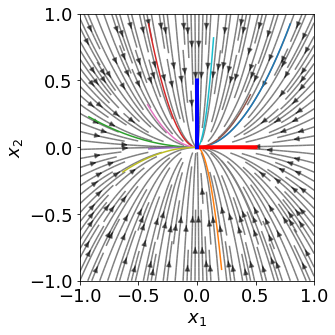

In [64]:
# hw2 p2a
A = np.array([[-1,0],[0,-2]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,density=2.,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

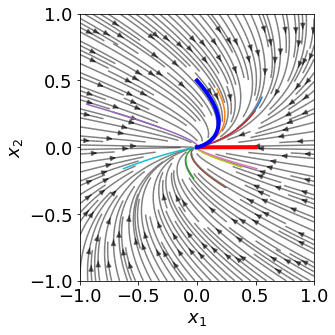

In [63]:
# hw2 p2b
A = np.array([[-1,1],[0,-1]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,density=2.,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

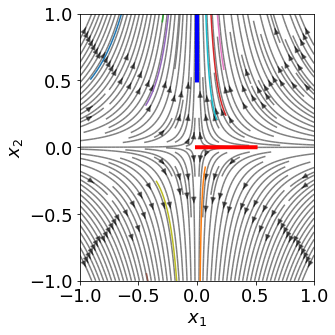

In [62]:
# hw2 p2c
A = np.array([[-1,0],[0,+2]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,density=2.,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

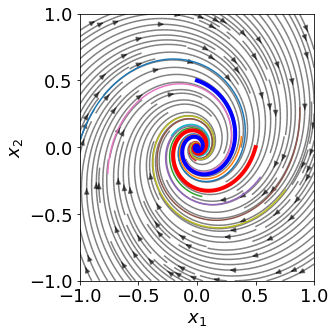

In [66]:
# hw2 p2d
A = np.array([[-1,np.pi],[-np.pi,-1]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,density=2.,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

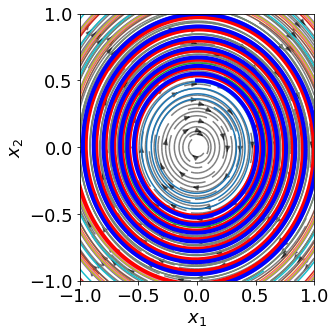

In [68]:
# hw2 p2e
A = np.array([[0,np.pi],[-np.pi,0]])

ut = lambda t : 0

def f(t,x,u):
  dx = np.dot(A,x)
  return dx

plt.figure(figsize=(5,5))

# simulation time
t = 15

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
X, Y = np.meshgrid(np.linspace(-1,+1, 11), np.linspace(-1, +1, 11))
dX,dY = np.asarray([f(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)
#ax.quiver(X,Y,dX,dY)
ax.streamplot(X,Y,dX,dY,density=2.,color=(0,0,0,.5))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)
  ax.plot(x_[:,0],x_[:,1])

t_,x_ = numerical_simulation(f,t,[.5,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'r',lw=4)
t_,x_ = numerical_simulation(f,t,[0,.5],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'b',lw=4)

ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))

plt.tight_layout()

Solution: 

The coordinate changes do not affect the transformed system. It remains unstable with the same eigenvalues.  

[-1.  2.]
[ 2. -1.]
[ 2. -1.]
[-1.  2.]


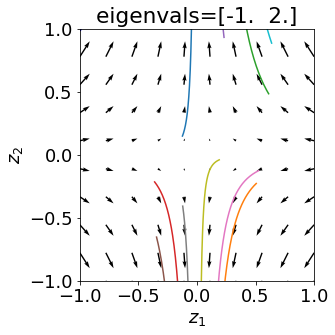

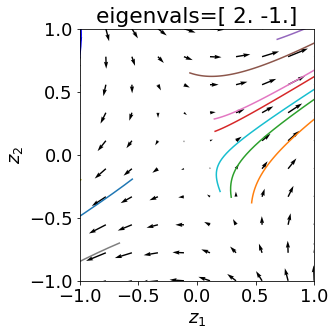

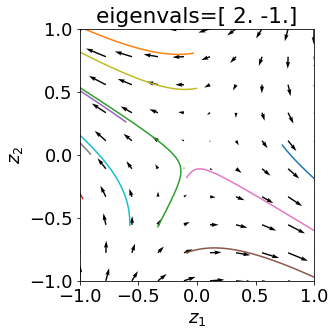

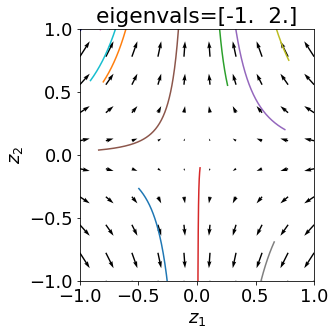

In [67]:
# question 2 f
A3 = np.array([[-1,0], 
     [0,+2]])
thetas = np.linspace(0,2*np.pi,4)# [0,np.pi/2,np.pi,3/2*np.pi]

#T = np.array([[np.cos(thetas),-np.sin(thetas)],[np.sin(thetas),np.cos(thetas)]])

for theta in thetas:
  def f(t,z,u):
      z1,z2 = z # charge, current
#       theta=0
      T = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
      return np.squeeze((np.matmul(np.matmul(np.matmul(T,A3),np.linalg.inv(T)),np.reshape(z,(2,1)))))

  plt.figure(figsize=(5,5))
  
  dt = 1e-2
  # initial condition
  z10,z20 = (-1.,1.)
  z0 = np.array([z10,z20])

  # simulation time
  t = 15
  t_,z_ = numerical_simulation(f,t,z0,dt=dt,ut=lambda t : 0)
  q_,dq_ = z_[:,0],z_[:,1]

  # print eigenvalues
  T = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
  A_ = np.matmul(np.matmul(T,A3),np.linalg.inv(T))
  w,_ = np.linalg.eig(A_)  
  print(w)

  # phase portrait / "quiver" plot
  ax = plt.subplot(1,1,1)
  Q, Qd = np.meshgrid(np.linspace(-1,+1, 10), np.linspace(-1, +1, 10))
  dQ,dQd = np.asarray([f(0.,(q,dq),0.).flatten() for q,dq in zip(Q.flatten(),Qd.flatten())]).T
  dQ,dQd = dQ.reshape(dQ.shape),dQd.reshape(Qd.shape)
  ax.quiver(Q,Qd,dQ,dQd)
  ax.set_xlabel(r'$z_1$')
  ax.set_ylabel(r'$z_2$')
  ax.set_xlim((-1,1))
  ax.set_ylim((-1,1))
  plt.title('eigenvals='+str(w))
  ax.plot(q_,dq_,'b',lw=4)

  for _ in range(10):
    # random initial condition in [-1,+1] x [-1,+1] square
    x0 = 2*(np.random.rand(2) - .5)
    t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
    q_,dq_ = x_[:,0],x_[:,1]
    ax.plot(q_,dq_)


  plt.tight_layout()

Solution:

$\dot{z}=SA_3S^-1z$ is a coordinate change of C.

[[ 0.75  -0.662]
 [ 0.662  0.75 ]]


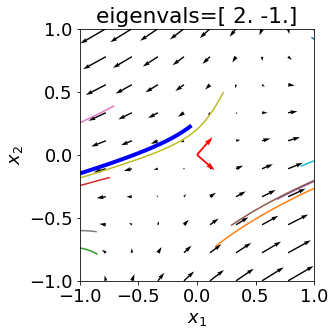

In [61]:
#question 2 g
A = np.array([[-1,0], [0,+2]])
S = np.array([[1,2],[2,0.5]])
def f(t,x,u):
    dx = np.squeeze((np.dot(np.dot(np.dot(S,A),np.linalg.inv(S)),np.reshape(x,(2,1))))) #x1,x2 = x # charge, current
    return dx
  
plt.figure(figsize=(5,5))
dt = 1e-2
# initial condition
#x10,x20 = (-1.,1.)
#x0 = np.array([x10,x20])
# simulation time
t = 15

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
q_,dq_ = x_[:,0],x_[:,1]

# calculate eigenvectors of S
w,v = np.linalg.eig(S)
print(v)

# phase portrait / "quiver" plot
ax = plt.subplot(1,1,1)
Q, Qd = np.meshgrid(np.linspace(-1,+1, 10), np.linspace(-1, +1, 10))
dQ,dQd = np.asarray([f(0.,(q,dq),0.).flatten() for q,dq in zip(Q.flatten(),Qd.flatten())]).T
dQ,dQd = dQ.reshape(dQ.shape),dQd.reshape(Qd.shape)
ax.quiver(Q,Qd,dQ,dQd)

A_ = np.matmul(np.matmul(S,A),np.linalg.inv(S))
#origin = [0],[0]
ax.quiver(0,0,0.75,-0.662,color='r',scale=10) # include eigenvectors of S to quiver plot
ax.quiver(0,0,0.662,0.75,color='r',scale=10)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
w,v = np.linalg.eig(A_)
plt.title('eigenvals='+str(w))
ax.plot(q_,dq_,'b',lw=4)

for _ in range(10):
  # random initial condition in [-1,+1] x [-1,+1] square
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=lambda t : 0)
  q_,dq_ = x_[:,0],x_[:,1]
  ax.plot(q_,dq_)
  
plt.tight_layout()